In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir('C:\\Users\\12451\\Desktop\\豆瓣电影')

### 读取电影基础信息

In [6]:
base_info = pd.read_excel('电影基本信息大全.xlsx')
base_info.head(2)

,ID,主演,导演,标记,海报,片名,网址,评分
0,26752088,"['徐峥', '王传君', '周一围', '谭卓', '章宇']",['文牧野'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,我不是药神,https://movie.douban.com/subject/26752088/,9.0
1,1295644,"['让·雷诺', '娜塔莉·波特曼', '加里·奥德曼', '丹尼·爱罗', '彼得·阿佩尔']",['吕克·贝松'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,这个杀手不太冷,https://movie.douban.com/subject/1295644/,9.4


### 读取电影详细信息

In [7]:
movie_info = pd.read_excel('电影详细信息.xlsx')
movie_info.head(2)

,上映时间,地区,热评,片名,片长,电影类型,简介,网址,评分人数,评分分布
0,-2018,中国大陆,王传君所有不被外人理解的坚持，都在这一刻得到了完美释放。他不是关谷神奇，他是王传君。\r\n...,我不是药神,117,"['剧情', '喜剧']",普通中年男子程勇（徐峥 饰）经营着一家保健品店，失意又失婚。不速之客吕受益（王传君 饰）的到...,https://movie.douban.com/subject/26752088/,1148470,"{'力荐': '57.6%', '推荐': '34.8%', '很差': '0.2%', '..."
1,-1994,法国,他们居然没做爱,这个杀手不太冷 Léon,110分钟(剧场版) / 133分钟(国际版)\r\n 又名: 杀手莱昂 / ...,"['剧情', '动作', '犯罪']",里昂（让·雷诺饰）是名孤独的职业杀手，受人雇佣。一天，邻居家小姑娘马蒂尔达（纳塔丽·波特曼饰...,https://movie.douban.com/subject/1295644/,1344085,"{'力荐': '74.1%', '推荐': '22.3%', '很差': '0.1%', '..."


## 数据清洗

### 1.双表合并

In [8]:
movie_combine = pd.merge(base_info,movie_info,left_on = '网址',right_on = '网址',how = 'inner')

### 2.上映时间清洗

In [9]:
movie_combine['上映时间'].head()

0    -2018
1    -1994
2    -1994
3    -2019
4    -2018
Name: 上映时间, dtype: object

In [10]:
movie_combine['上映时间'] = movie_combine['上映时间'] * -1
movie_combine['上映时间'].head()

0    2018
1    1994
2    1994
3    2019
4    2018
Name: 上映时间, dtype: object

### 3.评分分布规整

In [11]:
#查看评分分布字段的格式
print(type(movie_combine['评分分布'].values[0]))
movie_combine['评分分布'].values[0]

<class 'str'>


"{'力荐': '57.6%', '推荐': '34.8%', '很差': '0.2%', '还行': '6.9%', '较差': '0.5%'}"

In [12]:
#先替换成单引号
var = movie_combine['评分分布'].values[0].replace("\'",'\"')
#再进行解析
type(json.loads(var))

dict

In [13]:
#批量对评分进行操作
def transform(x):
    return json.loads(x.replace("\'",'\"'))

movie_combine['format_评分'] = movie_combine['评分分布'].apply(transform)

In [14]:
#把单列字典的评分分布转化成分开的5列，且每一列是数值型的
def get_rate(x,types):
    try:
        return float(x[types].strip('%'))
    except:
        pass
    
movie_combine['5星'] = movie_combine['format_评分'].apply(get_rate,types = '力荐')
movie_combine['4星'] = movie_combine['format_评分'].apply(get_rate,types = '推荐')
movie_combine['3星'] = movie_combine['format_评分'].apply(get_rate,types = '还行')
movie_combine['2星'] = movie_combine['format_评分'].apply(get_rate,types = '较差')
movie_combine['1星'] = movie_combine['format_评分'].apply(get_rate,types = '很差')

movie_combine.head(1)

,ID,主演,导演,标记,海报,片名_x,网址,评分,上映时间,地区,...,电影类型,简介,评分人数,评分分布,format_评分,5星,4星,3星,2星,1星
0,26752088,"['徐峥', '王传君', '周一围', '谭卓', '章宇']",['文牧野'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,我不是药神,https://movie.douban.com/subject/26752088/,9.0,2018,中国大陆,...,"['剧情', '喜剧']",普通中年男子程勇（徐峥 饰）经营着一家保健品店，失意又失婚。不速之客吕受益（王传君 饰）的到...,1148470,"{'力荐': '57.6%', '推荐': '34.8%', '很差': '0.2%', '...","{'较差': '0.5%', '还行': '6.9%', '推荐': '34.8%', '很...",57.6,34.8,6.9,0.5,0.2


## 数据分析

In [15]:
#按照总评分，5星评分人数占比，4星占比，3星..依次类推
movie_combine.sort_values(['评分','5星','4星','3星','2星','1星'],ascending = False,inplace = True)
movie_combine.head(1)

,ID,主演,导演,标记,海报,片名_x,网址,评分,上映时间,地区,...,电影类型,简介,评分人数,评分分布,format_评分,5星,4星,3星,2星,1星
5123,24751811,"['莱明·卡莱姆罗', '席爱拉·博格斯', '哈德利·弗雷泽', 'Earl Carpen...",['Nick Morris'],50,https://img3.doubanio.com/view/photo/s_ratio_p...,剧院魅影：25周年纪念演出,https://movie.douban.com/subject/24751811/,9.7,2011,英国,...,"['剧情', '音乐', '歌舞']",这是一场为庆祝音乐剧《剧院魅影》成功上演25周年的特别演出，地点在英国伦敦的皇家阿尔伯特音乐...,8835,"{'力荐': '87.8%', '推荐': '10.6%', '很差': '0.2%', '...","{'较差': '0.1%', '还行': '1.2%', '推荐': '10.6%', '很...",87.8,10.6,1.2,0.1,0.2


### 1.剔除掉没有评分的电影并绘制

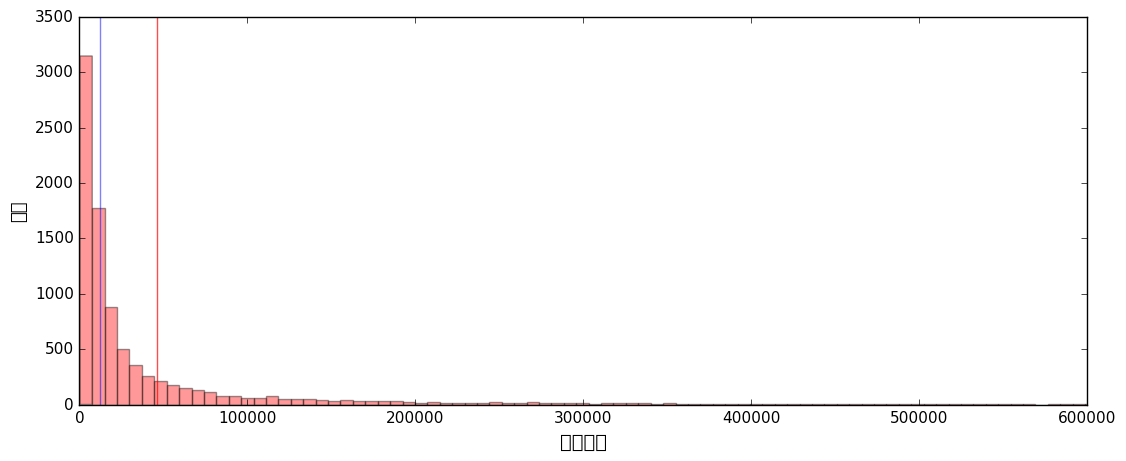

In [18]:
movie_combine = movie_combine.loc[movie_combine['评分人数'] != 'None',:]

fig,ax = plt.subplots(1,1,figsize = (13,5))
#plt.figure(figsize = (12,5))
sns.distplot(movie_combine['评分人数'].values,color = 'red',kde = False,bins = 200,ax = ax)
ax.axvline(movie_combine['评分人数'].mean(),color = 'red',alpha = 0.7)
ax.axvline(movie_combine['评分人数'].median(),color = 'blue',alpha = 0.5)
plt.xlim(0,600000)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
ax.set_xlabel('评分人数', fontsize=14)
ax.set_ylabel('数量', fontsize=13)

### 2.用中位数作为人数筛选机制

In [22]:
print('中位数:',movie_combine['评分人数'].median())
print('均值:',movie_combine['评分人数'].mean())
movie_f = movie_combine.loc[movie_combine['评分人数'] > movie_combine['评分人数'].median(),:]

中位数: 12315.5
均值: 46136.74067455886


### 3.上映时间和数量分布趋势

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


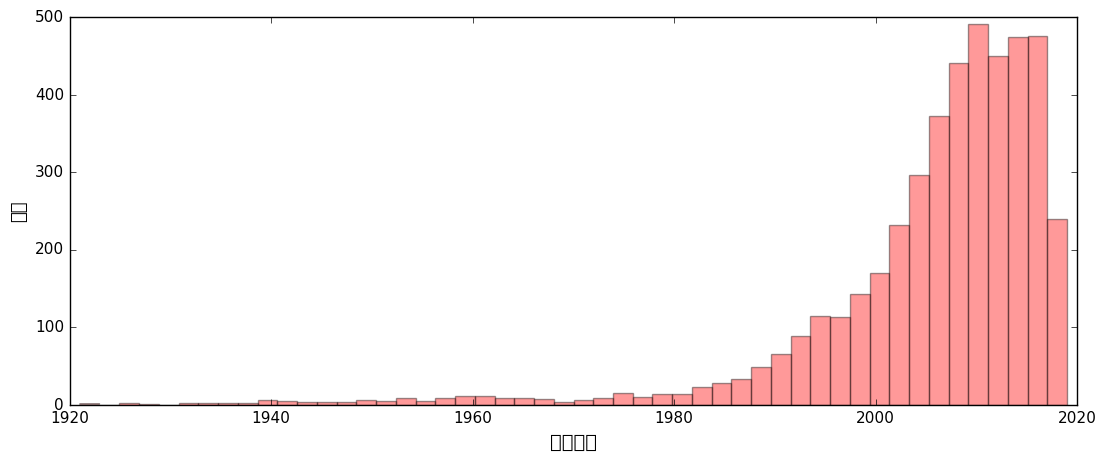

In [30]:
fig,ax = plt.subplots(1,1,figsize = (13,5))
sns.distplot(movie_f['上映时间'].values,color = 'red',kde = False,ax = ax)

plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
ax.set_xlabel('上映时间', fontsize=14)
ax.set_ylabel('数量', fontsize=13)

### 4.不同年代电影数量

In [33]:
labels = []
for i in range(1910,2020,10):
    if i < 2000:
        century = '20世纪{}年代'.format(str(i)[2:])
    else:
        century = '21世纪{}年代'.format(str(i)[2:])
    labels.append(century)
    
century_f= pd.cut(movie_f['上映时间'].values,bins = list(range(1910,2030,10)),right = False,labels = labels).value_counts()
century_f

20世纪10年代       0
20世纪20年代       4
20世纪30年代      10
20世纪40年代      20
20世纪50年代      38
20世纪60年代      44
20世纪70年代      53
20世纪80年代     145
20世纪90年代     522
21世纪00年代    1511
21世纪10年代    2130
dtype: int64

### 5.年代打标

In [34]:
movie_f['年代'] = pd.cut(movie_f['上映时间'].values,bins = list(range(1910,2030,10)),right = False,labels = labels)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [35]:
#先按照年代，再按照评分排序
movie_f.sort_values(['年代','评分'],ascending = False)

,ID,主演,导演,标记,海报,片名_x,网址,评分,上映时间,地区,...,简介,评分人数,评分分布,format_评分,5星,4星,3星,2星,1星,年代
2959,11615927,"['杉田智和', '钉宫理惠', '阪口大助', '千叶进步', '中井和哉']",['藤田阳一'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,银魂完结篇：直到永远的万事屋,https://movie.douban.com/subject/11615927/,9.3,2013,日本,...,银魂完结篇即将上演，坂田银时（杉田智和 配音）在影院抓住一个盗录的电影小偷，谁知刺眼的白光之...,28956,"{'力荐': '73.3%', '推荐': '19.0%', '很差': '0.4%', '...","{'较差': '0.6%', '还行': '6.7%', '推荐': '19.0%', '很...",73.3,19.0,6.7,0.6,0.4,21世纪10年代
3969,26700818,"['伊恩·麦克莱恩', '德里克·雅各比', '弗朗西斯·德·拉·图瓦', '伊万·瑞恩',...",['埃德·拜'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,极品基老伴：完结篇,https://movie.douban.com/subject/26700818/,9.3,2016,英国,...,A one-off special has been confirmed by ITV an...,17090,"{'力荐': '72.5%', '推荐': '22.2%', '很差': '0.3%', '...","{'较差': '0.4%', '还行': '4.7%', '推荐': '22.2%', '很...",72.5,22.2,4.7,0.4,0.3,21世纪10年代
6,3541415,"['莱昂纳多·迪卡普里奥', '约瑟夫·高登-莱维特', '艾伦·佩吉', '汤姆·哈迪',...",['克里斯托弗·诺兰'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,盗梦空间,https://movie.douban.com/subject/3541415/,9.3,2010,美国 / 英国,...,道姆·柯布（莱昂纳多·迪卡普里奥 Leonardo DiCaprio 饰）与同事阿瑟（约瑟夫...,1157943,"{'力荐': '70.1%', '推荐': '25.4%', '很差': '0.2%', '...","{'较差': '0.3%', '还行': '4.1%', '推荐': '25.4%', '很...",70.1,25.4,4.1,0.3,0.2,21世纪10年代
130,5912992,"['孔侑', '郑有美', '金志映', '金贤秀', '郑仁絮']",['黄东赫'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,熔炉,https://movie.douban.com/subject/5912992/,9.3,2011,韩国,...,来自首尔的哑语美术老师仁浩（孔宥 饰）来到雾津，应聘慈爱聋哑人学校。天降大雾，他意外撞车，维...,474228,"{'力荐': '69.2%', '推荐': '26.4%', '很差': '0.1%', '...","{'较差': '0.3%', '还行': '4.0%', '推荐': '26.4%', '很...",69.2,26.4,4.0,0.3,0.1,21世纪10年代
2775,27040774,"['裴斗娜', '杰米·克莱顿', '蒂娜·德赛', '塔彭丝·米德尔顿', '马克思·雷迈特']",['拉娜·沃卓斯基'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,超感猎杀：完结特别篇,https://movie.douban.com/subject/27040774/,9.2,2018,美国,...,Netfilx宣布将为月初被砍的《超感猎杀》制作两小时最终篇！Wolfgang的命运及更多大...,31228,"{'力荐': '71.0%', '推荐': '19.1%', '很差': '0.7%', '...","{'较差': '1.4%', '还行': '7.7%', '推荐': '19.1%', '很...",71.0,19.1,7.7,1.4,0.7,21世纪10年代
24,1889243,"['马修·麦康纳', '安妮·海瑟薇', '杰西卡·查斯坦', '卡西·阿弗莱克', '迈克...",['克里斯托弗·诺兰'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,星际穿越,https://movie.douban.com/subject/1889243/,9.2,2014,美国 / 英国 / 加拿大 / 冰岛,...,近未来的地球黄沙遍野，小麦、秋葵等基础农作物相继因枯萎病灭绝，人类不再像从前那样仰望星空，放...,830685,"{'力荐': '69.6%', '推荐': '24.5%', '很差': '0.4%', '...","{'较差': '0.5%', '还行': '5.1%', '推荐': '24.5%', '很...",69.6,24.5,5.1,0.5,0.4,21世纪10年代
3902,20453087,"['克里斯·奥多德', '理查德·艾欧阿德', '凯瑟琳·帕金森', '诺尔·费丁', '克...",['格雷厄姆·莱恩汉'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,IT狂人特别篇,https://movie.douban.com/subject/20453087/,9.2,2013,英国,...,曾卷起一股英式幽默风潮的情景喜剧《IT狂人》，在阔别观众2年多之后再度袭来！距第四季完结至今...,17463,"{'力荐': '69.1%', '推荐': '23.5%', '很差': '0.1%', '...","{'较差': '0.6%', '还行': '6.7%', '推荐': '23.5%', '很...",69.1,23.5,6.7,0.6,0.1,21世纪10年代
2466,6870362,"['罗伯特·巴瑟斯特', '休·博纳维尔', '布兰登·柯伊尔', '琼安·弗洛加特', '...",['布莱恩·派西维尔'],45,https://img1.doubanio.com/view/photo/s_ratio_p...,唐顿庄园：2011圣诞特别篇,https://movie.douban.com/subject/6870362/,9.2,2011,英国,...,处在贝茨先生（布兰登?柯伊尔 Brendan Coyle 饰）受审一事阴霾中的唐顿庄园迎来了...,35666,"{'力荐': '66.8%', '推荐': '28.3%', '很差': '0.0%', '...","{'较差': '0.2%', '还行': '4.7%', '推荐': '28.3%', '很...",66.8,28.3,4.7,0.2,0.0,21世纪10年代
74,6786002,"['弗朗索瓦·克鲁塞', '奥玛·希', '安娜·勒尼', '奥德雷·弗勒罗', '托马·索...","['奥利维埃·纳卡什', '埃里克·托莱达诺']",45,https://img3.doubanio.com/view/photo/s_ratio_p...,触不可及,https://movie.douban.com/subject/6786002/,9.2,2011,法国,...,因为一次跳伞事故，白人富翁菲利普Philippe（弗朗索瓦·克鲁塞 Fran?ois Clu...,556675,"{'力荐': '66.0%', '推荐': '28.9%', '很差': '0.1%', '...","{'较差': '0.3%', '还行': '4.7%', '推荐': '28.9%', '很...",66.0,28.9,4.7,0.3,0.1,21世纪10年代
244,21937445,"['宋康昊', '吴达洙', '金英爱', '郭度沅', '任时完']",['杨宇硕'],45,https://img3.doubanio.com/view/photo/s_ratio_p...,辩护人,https://movie.douban.com/subject/21937445/,9.2,2013,韩国,...,1978年，只有高中学历的宋佑硕（宋康昊 饰）通过多年的艰苦努力，终于通过司法考试，并在成为...,332735,"{'力荐': '65.3%', '推荐': '29.5%', '很差': '0.1%', '...","{'较差': '0.3%', '还行': '4.8%', '推荐': '29.5%', '很...",65.3,29.5,4.8,0.3,0.1,21世纪10年代


### 6.灵活筛选

In [36]:
final_rank = pd.DataFrame()
for century,count in zip(century_f.index,century_f.values):
    f1 = movie_f.loc[movie_f['年代'] == century,:]
    if count < 1000:
        return_num = int(count * 0.1)
    f2 = f1.iloc[:return_num,:]
    final_rank = pd.concat([final_rank,f2])

In [37]:
final_rank.head(1)

,ID,主演,导演,标记,海报,片名_x,网址,评分,上映时间,地区,...,简介,评分人数,评分分布,format_评分,5星,4星,3星,2星,1星,年代
1360,1293908,"['查理·卓别林', '弗吉尼亚·切瑞尔', '佛罗伦斯·李', '亨利·伯格曼', '珍·...",['查理·卓别林'],45,https://img1.doubanio.com/view/photo/s_ratio_p...,城市之光,https://movie.douban.com/subject/1293908/,9.3,1931,美国,...,他是一个流浪汉（查理·卓别林 Charles Chaplin 饰），身无分文，遇上了双目失明...,63334,"{'力荐': '68.5%', '推荐': '26.8%', '很差': '0.1%', '...","{'较差': '0.2%', '还行': '4.3%', '推荐': '26.8%', '很...",68.5,26.8,4.3,0.2,0.1,20世纪30年代


In [24]:
#final_rank.to_excel('最终电影排名结果.xlsx')

### 7.词云绘制

In [118]:
from pyecharts import WordCloud

myWordCloud = WordCloud("绘制词云",width=1000, height=200)

In [ ]:
#词云图暂时剔除掉包含篇、版相对小众的动漫
final_rank_f = final_rank.loc[(final_rank['片名_x'].str.find('篇') == -1) & 
                              (final_rank['片名_x'].str.find('版') == -1) &
                              (final_rank['片名_x'].str.find('界') == -1),:]

In [173]:
for i in final_rank_f['年代'].unique():
    name = final_rank_f.loc[final_rank_f['年代'] == i,'片名_x'].values[:5]
    value = final_rank_f.loc[final_rank_f['年代'] == i,'评分'].values[:5]
    names = []
    for n,v in zip(name,value):
        n = n + ' ' + str(v)
        names.append(n)
    myWordCloud = WordCloud(i,width=1000, height=500)
    myWordCloud.add("",attr = names,value = value,word_size_range=[30,40],shape = 'cardioid')
    myWordCloud.render(i + '.html')